In [33]:
import pandas as pd
import numpy as np
import requests
from PIL import Image, ImageSequence
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage, display
import imageio.v2 as imageio
from tqdm import tqdm
from IPython.display import HTML
from concurrent.futures import ThreadPoolExecutor, as_completed
import imageio
import urllib
import cv2


In [34]:
data = pd.read_csv("/Users/ishananand/Desktop/Text-To-Video-Generation/data/tgif-v1.0.tsv", sep='\t', header=None, names=['url', 'caption'])
data.head()

,url,caption
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,"a man is glaring, and someone with sunglasses ..."
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing.
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...


In [35]:
data['frames'] = 0

In [36]:
data.head()

,url,caption,frames
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,"a man is glaring, and someone with sunglasses ...",0
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet,0
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing.,0
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle,0
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...,0


In [37]:
data.shape

(125782, 3)

In [38]:
rl = data['url'][0]
resp = requests.get(rl)
img = Image.open(BytesIO(resp.content))
HTML(f'<img src="{rl}" />')


In [ ]:
invalid_urls = []

def process_url(i, url):
    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return i, None
        gif = imageio.mimread(BytesIO(resp.content))
        return i, len(gif)
    except Exception:
        return i, None

results = []
with ThreadPoolExecutor(max_workers=80) as executor:
    futures = {executor.submit(process_url, i, url): i for i, url in enumerate(data['url'])}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing URLs"):
        i, frame_count = future.result()
        if frame_count is None:
            invalid_urls.append(i)
        else:
            data.loc[i, "frames"] = frame_count


Processing URLs: 100%|██████████| 125782/125782 [46:27<00:00, 45.13it/s] 


In [ ]:
data.drop(index=invalid_urls, inplace=True)
data.to_csv("/Users/ishananand/Desktop/Text-To-Video-Generation/data/modified_tgif.csv", index=False, columns = ['url', 'caption', 'frames'])
len(invalid_urls)

In [40]:
df = pd.read_csv("/Users/ishananand/Desktop/Text-To-Video-Generation/data/modified_tgif.csv")
HTML(f'<img src="{df['url'][1]}" />')

In [41]:
df.shape

(125683, 3)

In [42]:
resp = requests.get(df['url'][1])
gif = imageio.mimread(BytesIO(resp.content))
print(f"Loaded {len(gif)} frames from GIF")
HTML(f'<img src="{df['url'][1]}" />')

Loaded 53 frames from GIF


(400, 313, 3)


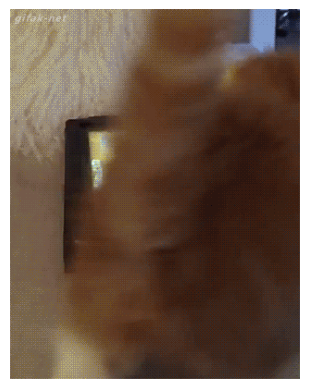

In [ ]:
url = df['url'][1]
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR_RGB)

print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()